In [1]:
from sklearn.datasets import fetch_mldata

In [2]:
#sometimes official server is down. Use this alternate method. Call this method and it will 
#download mnist and store it in the default location
from shutil import copyfileobj
from six.moves import urllib
from sklearn.datasets.base import get_data_home
import os

def fetch_mnist(data_home=None):
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    data_home = get_data_home(data_home=data_home)
    data_home = os.path.join(data_home, 'mldata')
    if not os.path.exists(data_home):
        os.makedirs(data_home)
    mnist_save_path = os.path.join(data_home, "mnist-original.mat")
    if not os.path.exists(mnist_save_path):
        mnist_url = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_save_path, "wb") as matlab_file:
            copyfileobj(mnist_url, matlab_file)

In [3]:
#fetch_mnist()
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [4]:
X,y = mnist["data"],mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek
at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using Matplotlib’s imshow() function:

(-0.5, 27.5, 27.5, -0.5)

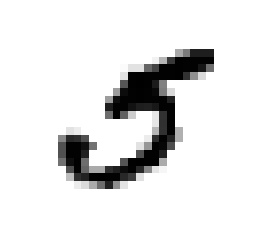

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
#plt.show()

In [7]:
print(y[36000])
print(X[36000])

5.0
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  86 131 225
 225 225   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  13  73 197 253 252 252 252 252   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   4  29  29 154 187 252 252 253
 252 252 233 145   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  29 252 253 252 252 252 252 253 204 11

split the training and testing data. Actually, MNIST data is already split into a training set (the first 60000 images) and a test set (the last 10000 images)

In [8]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

shuffle the training set. This will guarantee that all the cross-validation folds will be similar(you dont want on fold to be missing some digits). Moreover some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this wont happen.

In [9]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index],y_train[shuffle_index]

### Training a binary classifier

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [12]:
#now let us use this to predict
sgd_clf.predict([some_digit])

array([ True])

### Performance measures

#### Measuring accuracy using cross validation

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [14]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred==y_test_folds)
    print(n_correct/len(y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.94925


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9525


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.96445


In [15]:
#with shuffle turned on
skfold1 = StratifiedKFold(n_splits=3,random_state=42,shuffle=True)
sgd_clf1 = SGDClassifier(random_state=42)

for train_index, test_index in skfold1.split(X_train,y_train_5):
    X_train_fold = X_train[train_index]
    y_train_fold = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clf = clone(sgd_clf1)
    
    clf.fit(X_train_fold,y_train_fold)
    y_predict = clf.predict(X_test_fold)
    n_correct = sum(y_predict==y_test_fold)
    print(n_correct/len(y_predict))
    
    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9678


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9556


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.96085


In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

array([0.94925, 0.9525 , 0.96445])

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)

n5_clf = Never5Classifier()
cross_val_score(n5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.9113 , 0.9101 , 0.90755])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

In [47]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
print(y_train_pred[3600])
y_train_pred.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

False


(60000,)

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53675,   904],
       [ 1772,  3649]], dtype=int64)

precision = $\frac{TP}{TP + FP}$

recall (also called $sensitivity$ or $true$ $positive$ $rate$ $(TPR)$ = $\frac{TP}{TP + FN}$

In [20]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # 4347/(4347+1074)
#When it claims an image represents a 5, it is correct only 78% of the time

0.8014495936745003

In [21]:
recall_score(y_train_5, y_train_pred)
# It only detects 80% of the 5s.

0.6731230400295148

It is often convenient to combine precision and recall into a single metric called the F 1 score, in particular if you need a simple way to compare two classifiers. The F 1 score is the harmonic mean of precision and recall (Equation 3-3). Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F 1 score if both recall and precision are high.

### $F_1$ = $\frac{2}{\frac{1}{precision}+\frac{1}{recall}}$

###          = $2\times\frac{precision \times recall}{precision+recall}$

###          = $\frac{TP}{TP+\frac{FN+FP}{2}}$

The $F_1$ score favors classifiers that have similar precision and recall. This is not always what you want:
in some contexts you mostly care about precision, and in other contexts you really care about recall. For
example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a
classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than
a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such
cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other
hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your
classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few
false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is
called the $precision/recall$ $tradeoff$.

In [29]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7317024263084018

### Precision/Recall Tradeoff
To understand this tradeoff, let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want.

So how can you decide which threshold to use? For this you will first need to get the scores of all instances in the training set using the cross_val_predict() function again, but this time specifying that you want it to return decision scores instead of predictions.

In [22]:
y_scores = cross_val_predict(sgd_clf,X_train, y_train_5, cv=3, method="decision_function")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

Now with these scores you can compute precision and recall for all possible thresholds using the precision_recall_curve() function

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

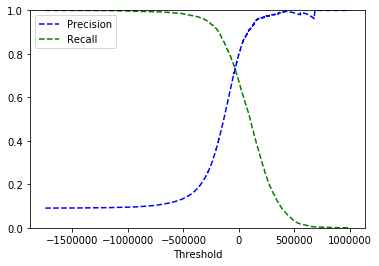

In [24]:
# finally we can plot precision and recall as functions of threshold value

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds, recalls[:-1],"g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Now you can simply select the threshold value that gives you the best precision/recall tradeoff for your task. Another way to select a good precision/recall tradeoff is to plot precision directly against recall

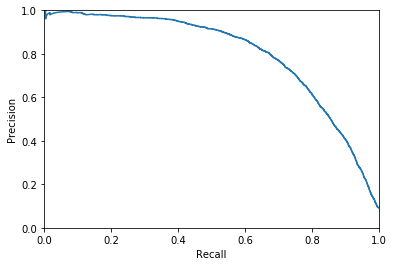

In [25]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.xlim([0,1])
    plt.ylim([0,1])
    
plot_precision_vs_recall(precisions, recalls)

You can see that precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall tradeoff just before that drop — for example, at around 60% recall. But of course the choice depends on your project.

So let’s suppose you decide to aim for 90% precision. You look up the first plot (zooming in a bit) and find that you need to use a threshold of about 70,000. To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can just run this code:

In [26]:
y_train_pred_90 = (y_scores > 70000)

In [27]:
#Let’s check these predictions’ precision and recall:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.8902728351126927
0.553772366722007


Great, you have a 90% precision classifier (or close enough)! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. Hmm, not so fast. A high-precision classifier is not very useful if its recall is too low!

# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.values.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)


# The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus 1 – specificity. 

To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the
roc_curve() function:

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

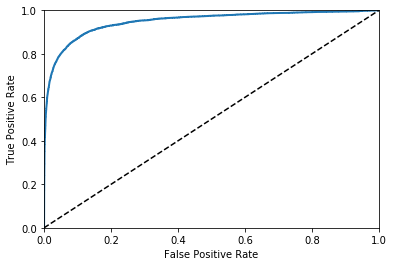

In [35]:
# now lets plot TPR vs FPR

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9488361718356101

Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC
AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner).

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier. First, you need to get scores for each instance in the training set. But due to the way it works (see Chapter 7), the RandomForestClassifier class does not have a decision_function() method. Instead it has a predict_proba() method. Scikit-Learn classifiers generally have one or the other. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5):

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [38]:
y_probas_forest.shape

(60000, 2)

But to plot a ROC curve, you need scores, not probabilities. A simple solution is to use the positive class’s probability as the score:

In [39]:
y_scores_forest = y_probas_forest[:,1] # score = probability of the positive class
fpr_forest, tpr_forest, thresholds = roc_curve(y_train_5, y_scores_forest)

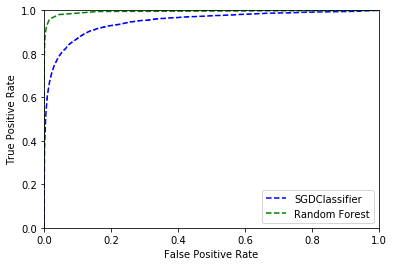

In [44]:
# now you are ready to plot the ROC curve. 
# it is useful to plot the first ROC curve to see how they compare

def plot_roc_curves(fpr,tpr,fpr_forest,tpr_forest):
    plt.plot(fpr,tpr,"b--",label="SGDClassifier")
    plt.plot(fpr_forest,tpr_forest,"g--",label="Random Forest")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curves(fpr,tpr,fpr_forest,tpr_forest)

RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better:

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.994079228497004

In [49]:
# precision and recall scores
y_predict_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print('Precision: ', precision_score(y_train_5, y_predict_forest))
print('Recall: ', recall_score(y_train_5, y_predict_forest))

Precision:  0.9849509269356598
Recall:  0.8330566316177827


# Multiclass Classification
Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes. Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are
strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

For example, one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-all (OvA) strategy (also called one-versus-the-rest).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. 

For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO). Let’s try this with the SGDClassifier:

In [50]:
sgd_clf.fit(X_train,y_train) #y_train , not y_train_5
sgd_clf.predict([some_digit])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([5.])

This code trains the SGDClassifier on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-all target classes (y_train_5). Then it makes a prediction (a correct one in this case). Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

To see that this is indeed the case, you can call the decision_function() method. Instead of returning just one score per instance, it now returns 10 scores, one per class:

In [53]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-120353.33007479, -463849.28362927, -254413.30638165,
        -197742.21424193, -381203.44619117,  112731.35857812,
        -812675.44671221, -280332.29768186, -707685.62633262,
        -618484.80729196]])

In [56]:
# the highest score is corresponding to index 5 which in this case also happens to be the class
print("classes: ",sgd_clf.classes_)
print('max index',np.argmax(some_digit_scores))
sgd_clf.classes_[np.argmax(some_digit_scores)]

classes:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
max index 5


5.0

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a binary classifier to its constructor. 

For example, this code creates a multiclass classifier using the OvO strategy, based on a SGDClassifier:

In [57]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

array([5.])

In [58]:
len(ovo_clf.estimators_)

45

In [59]:
# Training a Random FOrest Classifier is just as easy

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes. You can call predict_proba() to get the list of probabilities that the classifier assigned to each instance for each class:

In [60]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.1, 0.1, 0.8, 0. , 0. , 0. , 0. ]])

You can see that the classifier is fairly confident about its prediction: the 0.8 at the 5th index in the array means that the model estimates an 80% probability that the image represents a 5. It also thinks that the image could instead be a 0 or a 3 (10% chance each).

Now of course you want to evaluate these classifiers. As usual, you want to use cross-validation. Let’s evaluate the SGDClassifier’s accuracy using the cross_val_score() function:

In [61]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

array([0.84978004, 0.86324316, 0.86823023])

In [62]:
cross_val_score(forest_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.94406119, 0.94159708, 0.939991  ])

Lets look at the scores from SGDClassifier above. 

It gets over 84% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. For example, simply scaling the inputs (as discussed in Chapter 2) increases accuracy above 90%:

In [65]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

array([0.90961808, 0.90879544, 0.9093364 ])

# Multiclass confusion matrix

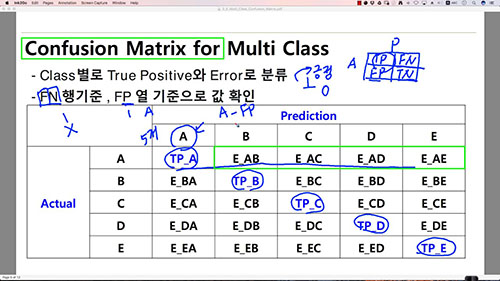

https://www.youtube.com/watch?v=FAr2GmWNbT0

- E_AB means - Error: Acutally A, wrongly classified as B
- TP_A: Means - True Positive. A is classified as A.
- The total number of test examples of any class would be the sum of the corresponding row (i.e. the TP + FN for that class)
- The total number of FN's for a class is the sum of values in the corresponding row (excluding the TP)
- The total number of FP's for a class is the sum of valuess in the corresponding column (excluding the TP)
- The total number of TN's for a certain class will be the sum of all columns and rows excluding that class's column and row